In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from tqdm import tqdm

import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from resnet_features import resnet50_features

In [4]:
device = torch.device('mps')

In [5]:
class Model(nn.Module):
    def __init__(
        self,
        img_size,
        prototype_shape,
        num_classes
    ):
        super(Model, self).__init__()
        self.img_size = img_size
        self.prototype_shape = prototype_shape
        self.num_classes = num_classes
        self.epsilon = 1e-4

        self.prototype_shape = [200, 128, 1, 1]
        self.proto_class_id = torch.zeros(self.prototype_shape[0], self.num_classes).to(device)

        num_proto_per_class = self.prototype_shape[0] // self.num_classes
        for j in range(self.prototype_shape[0]):
            self.proto_class_id[j, j // num_proto_per_class] = 1

        self.features = resnet50_features(pretrained=True)
        self.add_on_layers = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=self.prototype_shape[1], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.prototype_shape[1], out_channels=self.prototype_shape[1], kernel_size=1),
            nn.Sigmoid()
        )

        # self.pooling = nn.AdaptiveAvgPool2d((1, 1))

        self.prototype_vectors = nn.Parameter(torch.rand(self.prototype_shape), requires_grad=True)
        self.ones = nn.Parameter(torch.ones(self.prototype_shape), requires_grad=False)

        self.last_layer = nn.Linear(200, self.num_classes, bias=False)

    def conv_features(self, x):
        x = self.features(x)
        x = self.add_on_layers(x)
        return x
    
    def _l2_convolution(self, x):
        x2 = x ** 2
        x2_patch_sum = F.conv2d(input=x2, weight=self.ones) 
        
        p2 = self.prototype_vectors ** 2
        p2 = torch.sum(p2, dim=(1, 2, 3))
        p2_reshape = p2.view(-1, 1, 1)

        xp = F.conv2d(input=x, weight=self.prototype_vectors)
        intermediate_result = -2 * xp + p2_reshape
        distance = F.relu(x2_patch_sum + intermediate_result)

        return distance
    
    def prototype_distances(self, x):
        conv_features = self.conv_features(x)
        distances = self._l2_convolution(conv_features)
        return distances

    def distance_2_similarity(self, distances):
        return torch.log((distances + 1) / (distances + self.epsilon))

    def forward(self, x):
        distances = self.prototype_distances(x)
        min_distances = -F.max_pool2d(-distances, 
                                      kernel_size=(distances.size()[2],
                                                   distances.size()[3])) 
        min_distances = min_distances.view(-1, self.prototype_shape[0])
        prototype_activations = self.distance_2_similarity(min_distances)
        logits = self.last_layer(prototype_activations)
        
        return logits, min_distances

In [6]:
def train(model, train_dataloader, test_dataloader, optimizer, epochs=10):
    model.to(device)
    for e in range(epochs):
        train_correct = 0
        train_total = 0

        train_loss = 0.0
        train_cross_entropy = 0.0
        train_distance = 0.0
        train_batches = 0

        model.train()
        print('======== Epoch {}'.format(e))
        with tqdm(train_dataloader, total=len(train_dataloader), unit='batch') as train_tqdm:
            for image, label in train_tqdm:
                train_tqdm.set_description('\tTraining')
                inputs = image.to(device)
                targets = label.to(device)

                logits, min_distances = model(inputs)
                cross_entropy_loss = F.cross_entropy(logits, targets)

                # print(logits)
                max_dist = model.prototype_shape[1] * model.prototype_shape[2] * model.prototype_shape[3]
                prototypes_of_correct_class = torch.t(model.proto_class_id[:, label]).to(device)
                inverted_distance, _ = torch.max((max_dist - min_distances) * prototypes_of_correct_class, dim=1)
                cluster_cost = torch.mean(max_dist - inverted_distance)

                prototypes_of_wrong_class = 1 - prototypes_of_correct_class
                inverted_distances_to_nontarget_prototypes, _ = torch.max((max_dist - min_distances) * prototypes_of_wrong_class, dim=1)
                separation_cost = torch.mean(max_dist - inverted_distances_to_nontarget_prototypes) # maybe change
                
                loss = cross_entropy_loss + 0.8 * cluster_cost - 0.08 * separation_cost

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(logits.data, dim=1)
                train_total += targets.size(0)
                train_correct += (predicted == targets).sum().item()
                train_cross_entropy += cross_entropy_loss.item()
                train_distance += (0.8 * cluster_cost.item() - 0.08 * separation_cost.item())
                train_batches += 1
                train_tqdm.set_postfix(
                    loss=loss.item(),
                    cross_entropy=cross_entropy_loss.item(), 
                    distance=(0.8 * cluster_cost.item() - 0.08 * separation_cost.item()),
                    accuracy_so_far=(train_correct / train_total)
                )
        
        model.eval()
        test_total = 0
        test_correct = 0
        test_loss = 0.0
        test_batches = 0
        for i, (image, label) in enumerate(test_dataloader):
            with torch.no_grad():
                inputs = image.to(device)
                targets = label.to(device)

                logits, min_distances = model(inputs)
                loss = F.cross_entropy(logits, targets)

                _, predicted = torch.max(logits.data, dim=1)
                test_total += targets.size(0)
                test_correct += (predicted == targets).sum().item()
                test_loss += loss.item()
                test_batches += 1 

        print("\tTrain -- accuracy {}".format(train_correct / train_total))
        print("\t\t +++++ cross entropy: {} | distance: {}".format(train_cross_entropy / train_batches, train_distance / train_batches))
        print("\tTest -- accuracy {} | loss {}".format(test_correct / test_total, test_loss / test_batches))
        

In [7]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

normalize = transforms.Normalize(mean=mean,
                                 std=std)

In [8]:
# data_dir = '../../data/CUB_200_2011/images_20_classes/'

# dataset = datasets.ImageFolder(
#     data_dir,
#     transforms.Compose([
#         transforms.Resize(size=(224, 224)),
#         transforms.ToTensor(),
#         normalize
#     ]))

# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

# train_dataloader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=32, shuffle=True
# )

# test_dataloader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=32, shuffle=False
# )

In [9]:
train_dir = '../../data/cub200_cropped/train_cropped_augmented/'
test_dir = '../../data/cub200_cropped/test_cropped/'

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        normalize
    ]))
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True)

# test set
test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        normalize,
    ]))
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False)

In [10]:
# inp, lab = next(iter(train_dataloader))

In [11]:
model = Model(img_size=224, prototype_shape=(200, 128, 1, 1), num_classes=20)

joint_optimizer_specs = \
[{'params': model.features.parameters(), 'lr': 1e-4, 'weight_decay': 1e-3}, # bias are now also being regularized
 {'params': model.add_on_layers.parameters(), 'lr': 3e-3, 'weight_decay': 1e-3},
 {'params': model.prototype_vectors, 'lr': 3e-3},
]

joint_optimizer = torch.optim.Adam(joint_optimizer_specs)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(joint_optimizer, step_size=5, gamma=0.1)

In [12]:
train(model, train_dataloader, test_dataloader, optimizer, epochs=10)

======== Epoch 0


	Training: 100%|██████████| 545/545 [05:22<00:00,  1.69batch/s, accuracy_so_far=0.252, cross_entropy=1.96, distance=0.0664, loss=2.03]


	Train -- accuracy 0.252438884425571
		 +++++ cross entropy: 2.4867555386429534 | distance: 0.4702845995655847
	Test -- accuracy 0.3339805825242718 | loss 2.2050905718522915
======== Epoch 1


	Training:   7%|▋         | 39/545 [00:23<05:05,  1.66batch/s, accuracy_so_far=0.388, cross_entropy=2.01, distance=0.143, loss=2.15] 


KeyboardInterrupt: 

In [ ]:
sinput, slabel = next(iter(train_dataloader))

In [ ]:
sinput = sinput.to(device)
slabel = slabel.to(device)
model.to(device)

Model(
  (features): resnet50_features
  (add_on_layers): Sequential(
    (0): Conv2d(2048, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (3): Sigmoid()
  )
  (last_layer): Linear(in_features=200, out_features=20, bias=False)
)

In [ ]:
slogits, sdistances = model(sinput)

tensor([[[[0.4808, 0.4861, 0.5086,  ..., 0.4920, 0.5422, 0.5129],
          [0.4902, 0.4748, 0.4664,  ..., 0.4383, 0.4902, 0.4764],
          [0.4518, 0.4278, 0.4452,  ..., 0.4107, 0.4164, 0.4819],
          ...,
          [0.4646, 0.4826, 0.4831,  ..., 0.4558, 0.4958, 0.5129],
          [0.5189, 0.5077, 0.4986,  ..., 0.5115, 0.5049, 0.4866],
          [0.5160, 0.5061, 0.4794,  ..., 0.5145, 0.5041, 0.5102]],

         [[0.5130, 0.4930, 0.4904,  ..., 0.4733, 0.4790, 0.4112],
          [0.5259, 0.5315, 0.5617,  ..., 0.5144, 0.4622, 0.4974],
          [0.5425, 0.5730, 0.6014,  ..., 0.5203, 0.5066, 0.4975],
          ...,
          [0.4852, 0.4429, 0.5012,  ..., 0.4969, 0.5364, 0.5269],
          [0.4281, 0.4139, 0.4292,  ..., 0.5088, 0.5444, 0.5396],
          [0.4481, 0.4595, 0.4358,  ..., 0.5201, 0.5142, 0.5315]],

         [[0.6027, 0.5646, 0.5473,  ..., 0.4920, 0.5045, 0.5650],
          [0.5736, 0.5598, 0.5533,  ..., 0.5434, 0.5919, 0.6091],
          [0.4773, 0.4765, 0.5343,  ..., 0

In [ ]:
sdistances

tensor([[ 9.6474, 12.3511, 11.1433,  ..., 10.9181, 10.8873,  8.7041],
        [ 9.5799, 12.5973, 11.2047,  ..., 10.6900, 10.8296,  8.6445],
        [ 9.3999, 12.3816, 11.3444,  ..., 10.6753, 10.9797,  8.2963],
        ...,
        [ 9.3543, 12.3830, 11.2455,  ..., 10.8251, 10.9871,  8.4828],
        [ 9.5138, 12.6850, 11.2276,  ..., 10.8151, 10.9582,  8.5304],
        [ 9.5357, 12.4423, 11.1995,  ..., 10.9340, 10.7163,  8.5021]],
       device='mps:0', grad_fn=<ViewBackward0>)

In [ ]:
sdistances.shape

torch.Size([32, 200])

In [ ]:
slogits

tensor([[ 0.0274,  0.1246,  0.0161, -0.0150,  0.0253, -0.0239, -0.0244,  0.0350,
         -0.0973, -0.0813,  0.0805, -0.0703,  0.0150,  0.0345,  0.0163,  0.0200,
          0.0440,  0.0449,  0.0625, -0.0159],
        [ 0.0273,  0.1246,  0.0164, -0.0142,  0.0250, -0.0242, -0.0245,  0.0333,
         -0.0979, -0.0809,  0.0801, -0.0702,  0.0145,  0.0348,  0.0154,  0.0195,
          0.0430,  0.0447,  0.0620, -0.0159],
        [ 0.0270,  0.1243,  0.0162, -0.0155,  0.0248, -0.0241, -0.0240,  0.0340,
         -0.0981, -0.0812,  0.0808, -0.0711,  0.0146,  0.0362,  0.0158,  0.0196,
          0.0434,  0.0444,  0.0620, -0.0162],
        [ 0.0266,  0.1249,  0.0165, -0.0156,  0.0251, -0.0238, -0.0243,  0.0343,
         -0.0985, -0.0811,  0.0814, -0.0714,  0.0149,  0.0349,  0.0167,  0.0196,
          0.0434,  0.0443,  0.0630, -0.0159],
        [ 0.0272,  0.1240,  0.0166, -0.0152,  0.0246, -0.0237, -0.0255,  0.0347,
         -0.0977, -0.0806,  0.0805, -0.0704,  0.0143,  0.0337,  0.0160,  0.0191,
      

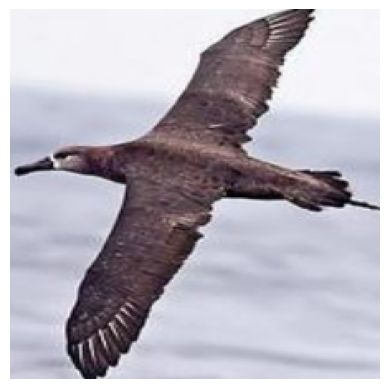

In [ ]:
import matplotlib.pyplot as plt

image_np = sinput[0].cpu().numpy().transpose(1, 2, 0)

# Display the image using matplotlib
plt.imshow(image_np)
plt.axis('off')  # Turn off axis labels
plt.show()